# Introduction
This Notebook contains my work for analyzing a 100km transect in the Southern Ocean. The goal is to identify Lee waves from the measurements and then estimate the energy fluxes and transport driven by these lee waves. 



In [178]:
# Load Data and relevant modules
%matplotlib inline
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
import data_load
import gsw
import oceans as oc
import pandas as pd
import internal_waves_calculations as iwc

pd.options.display.max_rows = 3000

pd.options.display.max_columns = 22


# load data and cut off bottom (its all nans)
ladcp, ctd = data_load.load_data()
strain = np.genfromtxt('strain.csv', delimiter=',')
wl_max = 1000
wl_min = 500
ctd_bin_size = 1024
ladcp_bin_size = 1024
nfft = 2048
U, V, p_ladcp = oc.loadLADCP(ladcp)
S, T, p_ctd, lat, lon = oc.loadCTD(ctd)

maxDepth = 4000
idx_ladcp = p_ladcp[:, -1] <= maxDepth
idx_ctd = p_ctd[:, -1] <= maxDepth

strain = strain[idx_ctd, :]
S = S[idx_ctd,:]
T = T[idx_ctd,:]
p_ctd = p_ctd[idx_ctd, :]
U = U[idx_ladcp, :]
V = V[idx_ladcp, :]
p_ladcp = p_ladcp[idx_ladcp, :]

# Bin CTD data
ctd_bins = oc.binData(S, p_ctd[:, 0], ctd_bin_size)
# Bin Ladcp Data
ladcp_bins = oc.binData(U, p_ladcp[:, 0], ladcp_bin_size)

# Depth and lat/long grids
depths = np.vstack([np.nanmean(p_ctd[binIn]) for binIn in ctd_bins])
dist = gsw.distance(lon, lat)
dist = np.cumsum(dist)/1000
dist = np.append(0,dist)

In [179]:
# use for reimporting modules that have been changed
import importlib
importlib.reload(iwc)

<module 'internal_waves_calculations' from '/Users/manishdevana/saltyPhysics/Lee_waves_dissertation/internal_waves_calculations.py'>

### Internal Energy Calculations
These calculations are a extracted from the internal_wave_calculations's wave_components_with_strain function. The final results here will be used to correct that function. **INSERT HOW THE INTERNAL ENERGY CALCULATIONS WORK HERE**



In [180]:
# Calculate potential energy density spectrum using adiabatic leveling
# --- This is the part that needs tweaking I think

# Adiabatic leveling following Bray and Fofonoff 1981 -
# the actual code is a python version of Alex Forryan's Matlab code

# Order = order of polynomial fit to use
order = 1

# Pressure window - See Bray and Fofonoff 1981 for details
plev = 400 

# axis = the depth increases on
axis = 0

# Calculate Buoyancy Frequency using GSW toolbox
N2, p_mid = gsw.stability.Nsquared(S, T, p_ctd, lat, axis=axis)

# Create empty grids to fill
alpha = np.full((p_mid.shape[0], p_mid.shape[1]), np.nan)
g = np.full((p_mid.shape[0], p_mid.shape[1]), np.nan)
rho_bar = np.full((p_mid.shape[0], p_mid.shape[1]), np.nan)
drho_dz = np.full((p_mid.shape[0], p_mid.shape[1]), np.nan)


for i in range(p_mid.shape[axis]):
    # Bottom and top for window - the max and min of the 2-element array
    # allows windows to run to ends of profile (I think)

    for k in range(p_mid.shape[1]):
        p_min = np.max([p_mid[i,k] - 0.5*plev, p_ctd[0,k]])
        p_max = np.min([p_mid[i,k] + 0.5*plev, p_ctd[-1,k]])
        data_in = np.logical_and(p_ctd >= p_min, p_ctd <= p_max)

        if np.sum(data_in) > 0:
            p_bar = np.nanmean(p_ctd[data_in[:,k],k])
            t_bar = np.nanmean(T[data_in[:,k],k])
            s_bar = np.nanmean(S[data_in[:,k],k])
            rho_bar[i,k] = gsw.density.rho(s_bar, t_bar, p_bar)

            # Potential Temperature referenced to pbar
            theta = gsw.conversions.pt_from_t(S[data_in[:,k],k],
                                              T[data_in[:,k],k],
                                              p_ctd[data_in[:,k],k],
                                              p_bar)

            sv = 1. / gsw.pot_rho_t_exact(S[data_in[:,k],k],
                                          theta,
                                          p_ctd[data_in[:,k],k],
                                          p_bar)


            # Regress pressure onto de-meaned specific volume and store coefficients
            Poly = np.polyfit(p_ctd[data_in[:,k],k], sv - np.nanmean(sv), order)

            # Do something with coefficients that I dont understand
            alpha[i,k] = Poly[order-1]

            # calculate reference N2 reference field
            g[i,k] = gsw.grav(lat.T[k], p_bar)

# Calculate N2 grid
N2_ref = -1e-4 * rho_bar**2 * g**2 * alpha

# strain calcuations
strain = (N2 - N2_ref) / N2_ref

# Append row of nans onto the top or bottom because computing N2 chops a row
# p_mid = np.vstack((np.zeros((1, p_mid.shape[1])), p_mid))
# rho_bar = np.vstack((np.full((1, p_mid.shape[1]), np.nan), rho_bar))



/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: Mean of empty slice


### Different ways of getting eta (isopyncal displacements)

**V1 - Waterman et al. 2013-using density surfaces**
This uses the equation:

$$ \eta = \frac{\rho - \rho_{ref}}{\frac{d\rho_{ref}}{dz}} $$

where rho reference is neutral density. I am going to try it with neutral density and with the adiabatically leveled density surfaces and see how different it is and why. $\frac{d\rho}{dz}$ is computed by differencing the reference density surfaces over a 400 meter vertical window. According to *Waterman et al. 2013* this window should not make a big difference. for the reference density the mean of all the adiabatically leveled profiles is taken as the stratification varies signficantly across the profile.


In [181]:
rho_ref = np.nanmean(rho_bar, axis=1)

# Stick a nan to the top to make it the same size as the rho array
rho_ref = np.hstack((0, rho_ref))

# set differnece window to 400 meters
win = 500

# Calculate eta (meters)

# since all the data is on a normalized pressure grid use a single vertical vector to make it easier to handle
z = -1*gsw.z_from_p(p_ctd[:,0], lat[:,0])
dz = np.nanmean(np.diff(z))
step = int(np.floor(.5*win/dz))
eta = np.full_like(rho, np.nan)
for i in range(rho.shape[0]):
    
    if i - step < 0:
        lower = 0
        upper = int(2*step)
        
    elif i + step > (rho.shape[0] - 1):
        lower = int(rho.shape[0] - 2*step)
        upper = -1 
        
    else:
        upper = i + step
        lower = i - step
    drefdz = (rho_ref[upper] - rho_ref[lower])/win
    
    eta[i,:] = (rho[i,:] -  rho_ref[i])/drefdz
        

### Get Spectrum to see how it worked
The kinetic energy calculations seem straight forward so they are just loaded in using the internal waves KE calculation function rather than show the whole code. Using these the wave components are calculated to see effects of different ways of potential energy calculations. 

In [182]:
# Calculate KE spectrums (m2/s2)
z_ladcp = -1*gsw.z_from_p(p_ladcp, lat)
KE, KE_grid, KE_psd, Uprime, Vprime, ke_peaks = iwc.KE_UV(U, V, z_ladcp, ladcp_bins,
                                                    wl_min, wl_max, lc=wl_min-50,
                                                    nfft=1024, detrend='constant')
# Calculate PE spectrum using eta from above (m2/s2)
z_ctd = -1*gsw.z_from_p(p_ctd, lat)
PE, PE_grid, eta_psd, N2mean, pe_peaks = iwc.PE(N2, z, eta,
                                                wl_min, wl_max,
                                 
                                                ctd_bins, nfft=1024,
                                                detrend=False)




/Users/manishdevana/saltyPhysics/Lee_waves_dissertation/internal_waves_calculations.py:257: RuntimeWarning: Mean of empty slice
  N2ref = np.nanmean(N2, axis=1)


/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


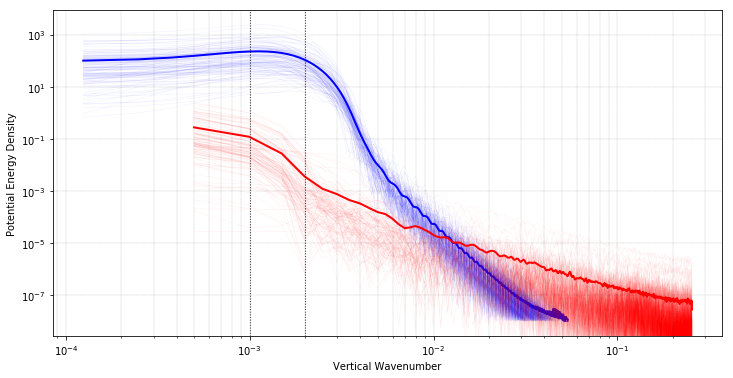

In [183]:
# Plot spectra to see what happened
m_plot = np.array([(1)/wl_max,
                       (1)/wl_max, (1)/wl_min,
                       (1)/wl_min])
plt.figure(figsize=[12,6])

plt.loglog(KE_grid, KE_psd.T, linewidth=.6, c='b', alpha=.05)
plt.loglog(KE_grid, np.nanmean(KE_psd, axis=0).T, lw=2, c='b')
ylims = plt.gca().get_ylim()
ylim1 = np.array([ylims[0], ylims[1]])
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim(ylims)
plt.ylabel('Kinetic Energy Density')
plt.xlabel('Vertical Wavenumber')
plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)

plt.loglog(PE_grid, .5*np.nanmean(N2)*eta_psd.T,
           lw=.6, c='r', alpha=.05)
plt.loglog(PE_grid, .5*np.nanmean(N2)*np.nanmean(eta_psd, axis=0).T,
           lw=2, c='r')
plt.plot(m_plot[2:], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.plot(m_plot[:2], ylim1, lw=1,
         c='k', alpha=.5,
         linestyle='dotted')
plt.ylim(ylims)
# plt.gca().grid(True, which="both", color='k', linestyle='dotted', linewidth=.2)
plt.ylabel('Potential Energy Density')
plt.xlabel('Vertical Wavenumber')
# plt.xlim(.0005, .01)

# Run Functions on data loaded in.

In [173]:
Etotal = 1027*(KE + PE) # Multiply by density to get Joules
display = pd.DataFrame(Etotal)
display

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.0014887,0.0006849,0.0003897,0.0020896,0.0005449,0.0057790,0.0038605,0.0084914,0.0025312,0.0004782,0.0005224,0.0009508,0.0001971,0.0019177,0.0011101,0.0009122,0.0018430,0.0031533,0.0038364,0.0019944,0.0022189
1,0.0049650,0.0068806,0.0099301,0.0079705,0.0028484,0.0257067,0.0245434,0.0223163,0.0112224,0.0019725,0.0009810,0.0022566,0.0026816,0.0107920,0.0145708,0.0063518,0.0134798,0.0091371,0.0102102,0.0134215,0.0084645
2,0.0136819,0.0279857,0.0240091,0.0050851,0.0076383,0.0149173,0.0407434,0.0248063,0.0076428,0.0107352,0.0018693,0.0020862,0.0103716,0.0314513,0.0310790,0.0185133,0.0159498,0.0065005,0.0112240,0.0119591,0.0158254
3,0.0700822,0.0802223,0.0336968,0.0052502,0.0088887,0.0053987,0.0699400,0.0156566,0.0053857,0.0055652,0.0060932,0.0198327,0.0112097,0.0436868,0.0269678,0.0211732,0.0106919,0.0095157,0.0149828,0.0028231,0.0144864
4,0.1179987,0.0896239,0.0579188,0.0096257,0.0108662,0.0053978,0.0127308,0.0045454,0.0310763,0.0159029,0.0095483,0.0078135,0.0323613,0.0077428,0.0243588,0.0266714,0.0192679,0.0345170,0.0200167,0.0126627,0.0470681
5,0.0848519,0.1634562,0.0358056,0.0068676,0.0017781,0.0260181,0.0135843,0.0165206,0.0466776,0.0206762,0.0312106,0.0080852,0.0797142,0.1114243,0.0110959,0.0380310,0.0620619,0.0434966,0.0158902,0.0528234,0.0482688


In [174]:
# wave components
f = np.nanmean(gsw.f(lat))

# version 2 omega calculation
omega = f*np.sqrt(((KE+PE)/(KE-PE)))



# version 2 omega calculation
omega2 = ((f**2)*((KE+PE)/(KE-PE)))
rw = KE/PE
w0 = ((f**2)*((rw+1)/(rw-1)))
m = (2*np.pi)/800

# version 1 kh calculation
kh = m*np.sqrt(((f**2 - omega**2)/(omega**2 - N2mean)))

# version 2 kh calculation
khi = (m/np.sqrt(N2mean))*(np.sqrt(omega**2 - f**2))
mask = kh == 0
kh[mask]= np.nan
lambdaH = 1e-3*(2*np.pi)/kh


/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/manishdevana/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [175]:
oc.display(lambdaH, caption="Horizontal Wavelength")


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [150]:
oc.display(omega)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,-0.0002176,-0.0007509,nan,-0.0001367,-0.0002744,-0.0001345,-0.0001809,-0.0001230,-0.0001485,-0.0001354,-0.0001356,-0.0001677,-0.0003890,-0.0001715,nan,nan,-0.0001285,-0.0001590,nan,-0.0001865,nan
1,-0.0001705,-0.0001370,-0.0001321,-0.0001239,-0.0001222,-0.0001183,-0.0001174,-0.0001180,-0.0001180,-0.0001237,-0.0001173,-0.0001176,-0.0001235,-0.0001176,-0.0001192,-0.0001288,-0.0001197,-0.0001230,-0.0001314,-0.0001243,-0.0001329
2,-0.0001398,-0.0001218,-0.0001211,-0.0001222,-0.0001178,-0.0001173,-0.0001170,-0.0001170,-0.0001171,-0.0001173,-0.0001170,-0.0001172,-0.0001176,-0.0001173,-0.0001173,-0.0001182,-0.0001182,-0.0001233,-0.0001259,-0.0001182,-0.0001189
3,-0.0001171,-0.0001170,-0.0001170,-0.0001171,-0.0001169,-0.0001170,-0.0001169,-0.0001169,-0.0001174,-0.0001170,-0.0001169,-0.0001169,-0.0001173,-0.0001170,-0.0001169,-0.0001177,-0.0001178,-0.0001182,-0.0001170,-0.0001172,-0.0001175
4,-0.0001169,-0.0001169,-0.0001169,-0.0001171,-0.0001171,-0.0001180,-0.0001169,-0.0001170,-0.0001171,-0.0001171,-0.0001170,-0.0001172,-0.0001172,-0.0001170,-0.0001174,-0.0001171,-0.0001171,-0.0001169,-0.0001174,-0.0001172,-0.0001170
5,-0.0001169,-0.0001169,-0.0001172,-0.0001178,-0.0001205,-0.0001172,-0.0001169,-0.0001169,-0.0001169,-0.0001169,-0.0001169,-0.0001172,-0.0001172,-0.0001169,-0.0001170,-0.0001169,-0.0001169,-0.0001169,-0.0001170,-0.0001169,-0.0001169


### Plotting velocity  Magntidude anomalies (version 1)


In [151]:
oc.display(eta)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,nan,nan,-0.4034069,nan,nan,nan,nan,nan,nan,nan,-0.3956895,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,nan,nan,-0.4017027,nan,nan,nan,-0.3660584,nan,nan,nan,-0.3925845,nan,nan,nan,nan,nan,nan,nan,-0.4402900,nan,nan
8,nan,nan,-0.4000284,nan,nan,nan,-0.3638999,nan,nan,nan,-0.3892864,nan,nan,nan,nan,nan,nan,nan,-0.4383855,nan,nan
9,nan,nan,-0.3982051,nan,nan,nan,-0.3618243,nan,nan,nan,-0.3869841,nan,nan,nan,nan,nan,nan,nan,-0.4366174,nan,nan
